# Generate EEG with Gaussian Processes
January 2022
Noam Siegel

In [1]:
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sklearn
import torch
from matplotlib.colors import LogNorm
from mlxtend.plotting import plot_decision_regions
from pytorch_lightning import seed_everything
from sklearn import preprocessing, svm, mixture
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

from msc.results_collectors import GPResultsCollector

seed_everything(42)
%load_ext autoreload
%autoreload 2

C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\noam\.virtualenvs\msc-WSmVxSSb\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 42


In [2]:
 # get results of multitask (pair) GP params MLE
requested_project_name = "inference/pairs"
requested_params = ['covar_module.data_covar_module.raw_outputscale',
                    'covar_module.data_covar_module.base_kernel.raw_lengthscale',
                    'covar_module.task_covar_module.covar_factor[0]',
                    'covar_module.task_covar_module.covar_factor[1]',
                    'covar_module.task_covar_module.raw_var[0]',
                    'covar_module.task_covar_module.raw_var[1]']

results_df = GPResultsCollector(requested_project_name, requested_params, n_pages=1).results_df

# get parameter values
X = results_df[requested_params].values

# calculate t-SNE values of parameters
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(X)

# add t-SNE results to results_df
results_df['tsne-2d-one'] = tsne_results[:, 0]
results_df['tsne-2d-two'] = tsne_results[:, 1]

getting page=1/1


C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\noam\.virtualenvs\msc-WSmVxSSb\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [3]:
results_df[requested_params + ['label_desc']]

,covar_module.data_covar_module.raw_outputscale,covar_module.data_covar_module.base_kernel.raw_lengthscale,covar_module.task_covar_module.covar_factor[0],covar_module.task_covar_module.covar_factor[1],covar_module.task_covar_module.raw_var[0],covar_module.task_covar_module.raw_var[1],label_desc
0,-0.751325,-4.126687,-0.570245,-0.212416,-1.749315,-0.920578,ictal
1,-1.112682,-4.066656,-0.408791,-0.692524,-0.923096,-1.005680,ictal
3,-1.263984,-4.304957,-0.627055,-0.635098,-2.228269,-1.859585,ictal
4,-1.944627,-4.084621,-1.423662,-0.255829,0.726123,0.289481,ictal
5,-1.012127,-3.766011,0.086742,-0.719742,0.926390,-0.764195,ictal
...,...,...,...,...,...,...,...
215,-1.978943,-4.717083,0.349365,0.128788,-4.230953,-2.990900,interictal
216,-1.300723,-4.455794,0.309201,0.060063,-3.371378,-2.398291,interictal
217,-1.694941,-4.809149,-0.371303,-0.003334,-2.323230,-1.633553,interictal
218,-2.076019,-4.869389,-0.461286,-0.051278,-3.914804,-1.546423,interictal


Text(0.5, 0.98, '2-channels Multitask Matern Params for Dog_1 Dataset')

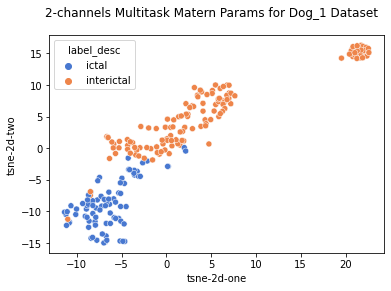

In [4]:
# plot t-sne results
sns.scatterplot(data=results_df,
              x='tsne-2d-one', y='tsne-2d-two',
              # hue_order=hue_order,
              hue="label_desc", palette="muted", legend=True)
plt.suptitle("2-channels Multitask Matern Params for Dog_1 Dataset")

## Check AUC ROC

In [20]:
# encode labels
le = preprocessing.LabelEncoder()
le.fit(results_df.label_desc)
results_df["label"] = le.transform(results_df.label_desc)

# get all data
X = results_df[requested_params].to_numpy()
y = results_df["label"].to_numpy()

# split train, test
X_train, X_test, y_train, y_test = train_test_split(X, y)

# train a classifier
clf = svm.SVC(kernel='linear', probability=True)
clf.fit(X, y)

SVC(kernel='linear', probability=True)

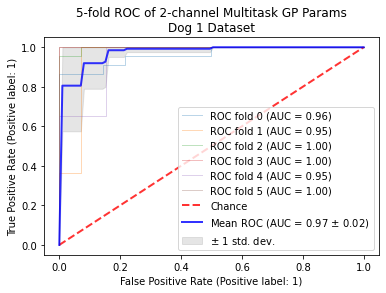

mean_auc=0.971703197987783


In [13]:
def plot_cv_roc_curve():
    from sklearn.metrics import auc
    from sklearn.metrics import RocCurveDisplay
    from sklearn.model_selection import StratifiedKFold
    ############################################################################
    # Classification and ROC analysis

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=6)
    classifier = svm.SVC(kernel="linear", probability=True, random_state=42)

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = RocCurveDisplay.from_estimator(
            classifier,
            X[test],
            y[test],
            name="ROC fold {}".format(i),
            alpha=0.3,
            lw=1,
            ax=ax,
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Chance", alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
    )

    ax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        title="5-fold ROC of 2-channel Multitask GP Params\nDog 1 Dataset",
    )
    ax.legend(loc="lower right")
    plt.show()
    print(f"{mean_auc=}")
plot_cv_roc_curve()

## Density estimation
We will use sklearn's Gaussian mixture models fit to the interictal data.

In [28]:
# fit a Gaussian Mixture Model with two components
gmm = mixture.GaussianMixture(n_components=2, covariance_type="full")
gmm.fit(X)

def plot_gmm_contour_plot():
    # display predicted scores by the model as a contour plot
    x = np.linspace(-10.0, 10.0)
    y = np.linspace(-10.0, 10.0)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -gmm.score_samples(XX)
    Z = Z.reshape(X.shape)

    CS = plt.contour(
        X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10)
    )
    CB = plt.colorbar(CS, shrink=0.8, extend="both")
    plt.scatter(X[:, 0], X[:, 1], 0.8)

    # add axes annotations
    plt.xlabel(requested_params[0])
    plt.ylabel(requested_params[1])

    # add title
    plt.title("Negative log-likelihood predicted by a GMM\nFit to interictal")
    plt.axis("tight")
    plt.show()

# plot_gmm_contour_plot()  # plots in 2-d but multitask EEG has more than 2 features.

## Sample from density estimator

In [32]:
# sample GP model params
params, _ = gmm.sample()

In [34]:
class multiChannelEEGGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        gpytorch.models.ExactGP.__init__(self, train_x, train_y, likelihood)
        num_tasks = train_y.size(-1)

        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.MaternKernel(1.5),
            num_tasks=num_tasks, rank=num_tasks
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        cover_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, cover_x)

## Initialize Gaussian process from sampled params

In [45]:
requ

multiChannelEEGGPModel(
  (likelihood): MultitaskGaussianLikelihood(
    (raw_task_noises_constraint): GreaterThan(1.000E-04)
    (raw_noise_constraint): GreaterThan(1.000E-04)
  )
  (mean_module): MultitaskMean(
    (base_means): ModuleList(
      (0): ZeroMean()
    )
  )
  (covar_module): MultitaskKernel(
    (task_covar_module): IndexKernel(
      (raw_var_constraint): Positive()
    )
    (data_covar_module): MaternKernel(
      (raw_lengthscale_constraint): Positive()
    )
  )
)

In [46]:
requested_params

['covar_module.data_covar_module.raw_outputscale',
 'covar_module.data_covar_module.base_kernel.raw_lengthscale',
 'covar_module.task_covar_module.covar_factor[0]',
 'covar_module.task_covar_module.covar_factor[1]',
 'covar_module.task_covar_module.raw_var[0]',
 'covar_module.task_covar_module.raw_var[1]']

In [52]:
model.covar_module.task_covar_module.covar_factor

Parameter containing:
tensor([], size=(0, 0), requires_grad=True)

In [43]:
# build GP model from sampled params
num_tasks = 2  # paired channels
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=num_tasks)
times = torch.linspace(0, 1, 401)
model = multiChannelEEGGPModel(torch.Tensor(), torch.Tensor(), likelihood)
model.covar_module.raw_outputscale.data.fill_(params[0, 0])
model.covar_module.base_kernel.raw_lengthscale.data.fill_(params[0, 1]);

AttributeError: 'MultitaskKernel' object has no attribute 'raw_outputscale'

## Sample EEG from Gaussian process

In [ ]:
# sample EEG from GP model
n_channels = 8
sample = model(times).sample(torch.Size([n_channels]))

# plot EEG sample
plt.clf()
fig = plt.gcf()
ax = fig.add_subplot()
ax.set_xlabel("time (s)")
for i in range(len(sample)):
    channel = sample[i]
    channel += i
    ax.plot(times, channel)
plt.title("sampled EEG")
plt.show()

## Generate more samples

In [ ]:
def sample_EEG(N=10):
    for i in range(N):
        # sample GP model params
        params, _ = gmm.sample()
        print(f"{params=}")
        # build GP model from sampled params
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        times = torch.linspace(0, 1, 401)
        model = EEGGPModel([], [], likelihood)
        model.covar_module.raw_outputscale.data.fill_(params[0, 0])
        model.covar_module.base_kernel.raw_lengthscale.data.fill_(params[0, 1])

        # sample EEG from GP model
        n_channels = 8
        sample = model(times).sample(torch.Size([n_channels]))

        # plot EEG sample
        plt.clf()
        fig = plt.gcf()
        ax = fig.add_subplot()
        ax.set_xlabel("time (s)")
        for i in range(len(sample)):
            channel = sample[i]
            channel += i
            ax.plot(times, channel)
        plt.title("sampled EEG")
        plt.show()

sample_EEG()